In [1]:
import os
os.chdir('../')

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [3]:
import torch
data_path = "/data2/wlsgur4011/SparseDC/datas/cache/1.marigold(vanilla)_a8b9d00ddfebe9d72ec8a22fdb190230.pt"
data = torch.load(data_path)
import jhutil; jhutil.jhprint(1111, data)

1111  {
    "name": "1.marigold(vanilla)",
    "image": "<PIL.Image.Image image mode=RGB size=304x228 at 0x7FF7B82B09A0>",
    "depth_pred": "tensor[228, 304] n=69312 (0.3Mb) x∈[0.002, 1.000] μ=0.240 σ=0.264 cuda:0",
    "rgb": "tensor[1, 3, 228, 304] n=207936 (0.8Mb) x∈[0., 1.000] μ=0.535 σ=0.303 cuda:0",
    "dep": "tensor[1, 1, 228, 304] n=69312 (0.3Mb) x∈[0., 6.848] μ=0.013 σ=0.201 cuda:0",
    "gt": "tensor[1, 1, 228, 304] n=69312 (0.3Mb) x∈[1.000, 7.159] μ=2.408 σ=1.605 cuda:0"
}


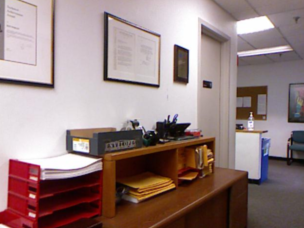

In [4]:
data["image"]

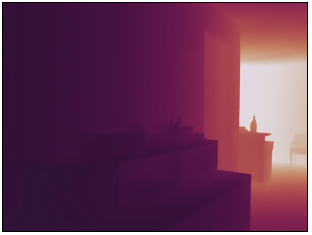

In [5]:
data["depth_pred"].chans

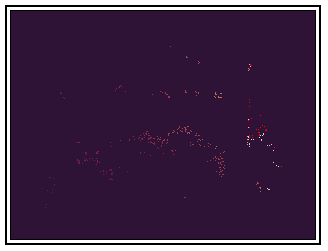

In [6]:
(data["dep"] / 5).chans

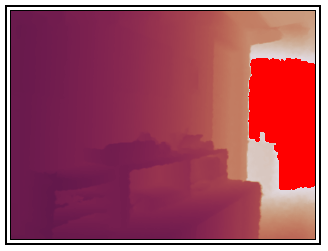

In [7]:
(data["gt"] / 5).chans

In [8]:
from src.utils.depth_utils import get_depth_affine, get_depth_dbscan
from src.utils.depth_utils import *


def compare_dbscan_and_affine(data):
    depth_gt_sparse = data["dep"][0][0]
    depth_estim = data["depth_pred"]
    mask_sparse = depth_gt_sparse != 0
    
    depth_dbscan, dbscan_mask = get_depth_dbscan(depth_estim, depth_gt_sparse)
    depth_affine = get_depth_affine(depth_estim, depth_gt_sparse)
    
    depth_gt = data["gt"][0][0]
    diff_dbscan = depth_dbscan - depth_gt
    diff_affine = depth_affine - depth_gt
    
    
    return diff_dbscan * dbscan_mask, diff_affine * dbscan_mask

diff_dbscan, diff_affine = compare_dbscan_and_affine(data)
import jhutil; jhutil.jhprint(1111, "ERR dbscan", diff_dbscan.abs().mean())
import jhutil; jhutil.jhprint(2222, "ERR affine", diff_affine.abs().mean())

[2024-02-07 20:34:27] [INFO] Created a temporary directory at /tmp/tmpbcdx34wf
[2024-02-07 20:34:27] [INFO] Writing /tmp/tmpbcdx34wf/_remote_module_non_scriptable.py
1111  "ERR dbscan" "tensor cuda:0 0.162"
2222  "ERR affine" "tensor cuda:0 0.136"


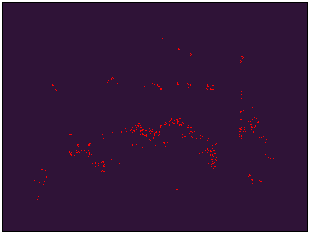

In [20]:
data["dep"][0][0]

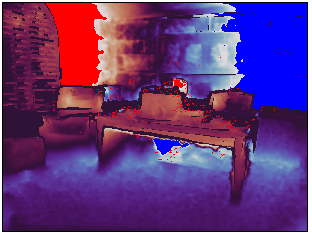

In [78]:
(diff_dbscan + data["dep"][0][0]).chans

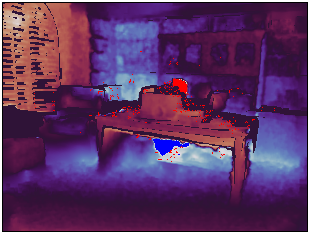

In [79]:
(diff_affine + data["dep"][0][0]).chans

In [39]:
import numpy as np
data_folder = "/data2/wlsgur4011/SparseDC/datas/cache"

err_dbscan_list = []
err_affine_list = []

data_path_iter = iter(os.listdir(data_folder))


In [66]:
while True:    
    data_path = next(data_path_iter)
    data = torch.load(os.path.join(data_folder, data_path))
    diff_dbscan, diff_affine = compare_dbscan_and_affine(data)
    err_dbscan = diff_dbscan.abs().mean().cpu().numpy()
    err_affine = diff_affine.abs().mean().cpu().numpy()
    # err_dbscan_list.append(err_dbscan)
    # err_affine_list.append(err_affine)
    if err_affine < err_dbscan / 2:
        break

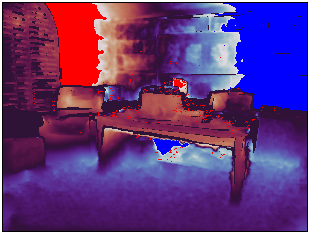

In [67]:
(diff_dbscan + data["dep"][0][0] * 100).chans

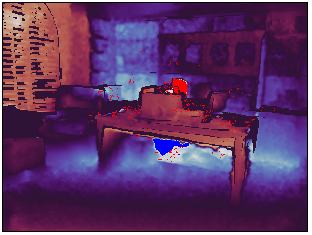

In [68]:
(diff_affine + data["dep"][0][0]).chans

In [23]:
import jhutil; jhutil.jhprint(1111, np.mean(err_dbscan_list))
import jhutil; jhutil.jhprint(2222, np.mean(err_affine_list))

1111  "0.23241523"
2222  "0.24943827"


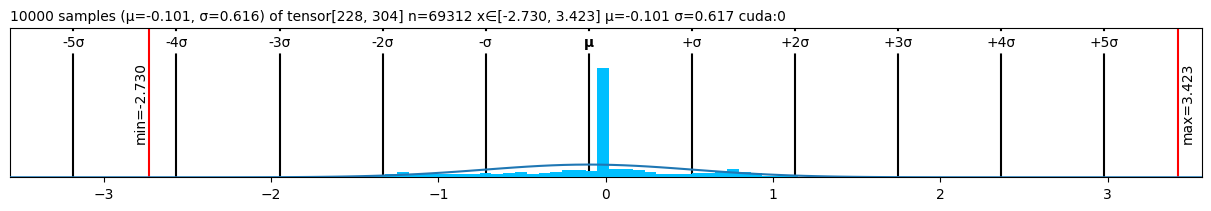

In [30]:
diff_affine.plt